In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import torch


seed = 1712
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
hidden_channels = 64
num_gnn_layers = 3

In [74]:
num_rounds = 500
num_epochs = 2
eval_round = num_rounds//10
batch_size = 32
num_train = 500

num_test = 1000
num_eval = 500

lr = 5e-4
step_size = num_rounds//10
gamma = 0.8

client_fraction = 0.6

num_epochs_cen = 1000
cen_lr = 5e-3

In [75]:
num_ue = 6
num_ap = 30
num_antenna = 1
tau=20; power_f=0.2; D=1; f=1900; Hb=15; Hm=1.65; d0=0.01;d1=0.05;


noise_p = 10**((-203.975+10*np.log10(20*10**6)+9)/10);
rho_d = power_f/noise_p
rho_p = power_f/noise_p

In [76]:
num_clients = num_ap
eval_round = eval_round if eval_round else num_rounds//10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create Data

In [77]:
from Utils.data_gen import create_graph, build_loader
from torch_geometric.loader import DataLoader




In [78]:
import scipy.io
from Utils.data_gen import build_cen_loader, build_decen_loader


file_name = f'dl_data_with_power_10000_{num_ue}_{num_ap}'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
beta_all = mat_data['betas']
gamma_all = mat_data['Gammas']
power_all = mat_data['power']/rho_d
phi_all = mat_data['Phii_cf'].transpose(0, 2, 1)
opt_train_rates = mat_data['R_cf_opt_min'][0]

label_all = power_all

perm = np.random.RandomState(seed).permutation(beta_all.shape[0])
train_idx = perm[:num_train]
test_idx  = perm[num_train: num_train + num_test]


## Decentralized Data
# Beta_all, Phi_all = beta_all[train_idx], phi_all[train_idx]
# train_data = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het')
# train_loader = build_loader(train_data, batch_size, seed=seed, drop_last=True)

# Beta_test, Phi_test = beta_all[test_idx], phi_all[test_idx]
# test_data = create_graph(Beta_test, Phi_test, beta_mean, beta_std, 'het')
# test_loader = build_loader(test_data, batch_size, seed=seed, drop_last=True)

train_data, train_loader = build_decen_loader(
    beta_all[train_idx],
    gamma_all[train_idx], 
    label_all[train_idx],
    phi_all[train_idx],
    batch_size, seed=seed
)
test_data, test_loader = build_decen_loader(
    beta_all[test_idx], 
    gamma_all[test_idx],
    label_all[test_idx],
    phi_all[test_idx], 
    batch_size, seed=seed
)



## Centralized Data
train_data_cen, train_loader_cen = build_cen_loader(
    beta_all[train_idx],
    gamma_all[train_idx], 
    label_all[train_idx],
    phi_all[train_idx],
    batch_size, isShuffle=True
)
test_data_cen, test_loader_cen = build_cen_loader(
    beta_all[test_idx], 
    gamma_all[test_idx],
    label_all[test_idx],
    phi_all[test_idx], 
    batch_size
)

# Init Model

In [79]:
from Models.GNN import APHetNet
from torch.optim.lr_scheduler import StepLR


In [ ]:
# Model Meta
ap_dim = train_data[0][0]['AP'].x.shape[1]
ue_dim = train_data[0][0]['UE'].x.shape[1]
edge_dim = train_data[0][0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,
}

# Initialize the models, optimizers, and schedulers for clients
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels//2,
).to(device)

local_models, optimizers, schedulers = [], [], []
for _ in range(num_clients):
    model = APHetNet(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels//2,
    ).to(device)
    model.load_state_dict(global_model.state_dict())
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
    # scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    local_models.append(model)
    optimizers.append(optimizer)
    # schedulers.append(scheduler)

In [81]:
from Utils.decentralized_train import FedAvg
fed = FedAvg(client_fraction=client_fraction)

In [ ]:
def lr_factor(round_idx, warmup_rounds=warmup_rounds, gamma=lr_gamma):
    """Round-wise LR factor in (0, 1]. round_idx is 0-based."""
    if round_idx < warmup_rounds:
        # linear warmup
        return float(round_idx + 1) / warmup_rounds
    else:
        # slow exponential decay
        return gamma ** (round_idx - warmup_rounds)

In [ ]:

import copy
from Utils.decentralized_train import fl_train, fl_eval_rate, get_global_info, distribute_global_info


fl_all_rate = []
fl_all_rate_test = []
for round in range(num_rounds):
    factor = lr_factor(round)                # in (0, 1]
    current_lr = lr * factor
    for opt in optimizers:
        for pg in opt.param_groups:
            pg['lr'] = current_lr
    total_train_rate = fl_eval_rate(
        train_loader, local_models,
        tau=tau, rho_p=power_f, rho_d=power_f, 
        num_antenna=num_antenna
    )
    total_eval_rate = fl_eval_rate(
        test_loader, local_models,
        tau=tau, rho_p=power_f, rho_d=power_f, 
        num_antenna=num_antenna
    )

    # Exchange global information
    send_to_server = get_global_info(
        train_loader, local_models, optimizers, 
        tau=tau, rho_p=power_f, rho_d=power_f, 
        num_antenna=num_antenna
    )
    response_all = distribute_global_info(send_to_server)

    # Train local models
    local_weights = []
    local_gradients = []
    total_loss = 0.0
    selected_clients = fed.sample_clients(num_clients)
    
    for client_idx, (model, opt, sch, batches, responses_ap) in enumerate(zip(local_models, optimizers, schedulers, train_loader, response_all)):
        if client_idx not in selected_clients:
            local_weights.append(copy.deepcopy(model.state_dict()))
            local_gradients.append(None)
            continue
        for epoch in range(num_epochs):
            train_loss, local_gradient = fl_train(
                batches, responses_ap, model, opt, 
                tau=tau, rho_p=power_f, rho_d=power_f, 
                num_antenna=num_antenna,
                epochRatio=round/(2*num_rounds/3)
            )
            # optimizer.step()
            # sch.step()
        local_weights.append(copy.deepcopy(model.state_dict()))
        local_gradients.append(local_gradient)
        total_loss += train_loss
        
    
    # for sch in schedulers:
    #     sch.step()
        

    avg_loss = total_loss / len(selected_clients)
    global_weights = fed.aggregate(local_weights, selected_clients)
    
    global_model.load_state_dict(global_weights)
    # Update global models
    for model in local_models:
        model.load_state_dict(global_weights)

    fl_all_rate.append(total_train_rate)
    fl_all_rate_test.append(total_eval_rate)
    if round % eval_round == 0:
        # lrs = [opt.param_groups[0]['lr'] for opt in optimizers]
        # print(f"[Round {round+1}] client LR: mean={np.mean(lrs):.3e}  min={np.min(lrs):.3e}  max={np.max(lrs):.3e}")
        print(f"Round {round+1:03d}/{num_rounds}: "
            f"Avg Training Loss = {avg_loss:.4f} | "
            f"Avg Training Rate = {total_train_rate:.4f} | "
            f"Avg Eval Rate = {total_eval_rate:.4f} | "
        )

/home/wine-4/miniconda3/envs/GNN_FL/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Round 001/500: Avg Training Loss = 0.0096 | Avg Training Rate = 0.4429 | Avg Eval Rate = 0.4747 | 


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=180)
plt.plot(fl_all_rate, label='Training Rate', linewidth=2)
plt.plot(fl_all_rate_test, label='Testing Rate', linewidth=2)
plt.axhline(y=np.mean(opt_train_rates[train_idx]), linewidth=2, color='r', linestyle='--', label='Training Optimal')
plt.axhline(y=np.mean(opt_train_rates[test_idx]), linewidth=2, color='b', linestyle='--', label='Testing Optimal')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('Centralized GNN Training Rate Curve', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Centralized Model

In [47]:
torch.set_default_dtype(torch.float32) 

num_gnn_layers = 3
num_epochs_cen = 1000
cen_lr = 2e-3 # 5e-3  the the best results
batch_size = 32
hidden_channels = 64 # min 32

In [48]:
import scipy.io
from Utils.data_gen import build_cen_loader


file_name = f'dl_data_with_power_10000_{num_ue}_{num_ap}'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
beta_all = mat_data['betas']
gamma_all = mat_data['Gammas']
power_all = mat_data['power']/rho_d
phi_all = mat_data['Phii_cf'].transpose(0, 2, 1)
opt_train_rates = mat_data['R_cf_opt_min'][0]

label_all = opt_train_rates

perm = np.random.RandomState(seed).permutation(beta_all.shape[0])
train_idx = perm[:num_train]
test_idx  = perm[num_train: num_train + num_test]

train_data_cen, train_loader_cen = build_cen_loader(
    beta_all[train_idx],
    gamma_all[train_idx], 
    label_all[train_idx],
    phi_all[train_idx],
    batch_size, isShuffle=True
)
test_data_cen, test_loader_cen = build_cen_loader(
    beta_all[test_idx], 
    gamma_all[test_idx],
    label_all[test_idx],
    phi_all[test_idx], 
    batch_size
)

In [49]:
# Model Meta
ap_dim = train_data_cen[0]['AP'].x.shape[1]
ue_dim = train_data_cen[0]['UE'].x.shape[1]
edge_dim = train_data_cen[0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,
}

In [50]:

from Models.GNN import APHetNet

cen_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels//2,
).to(device)
torch.nn.utils.clip_grad_norm_(cen_model.parameters(), 1.0)
# cen_optimizer = torch.optim.Adam(cen_model.parameters(), lr=cen_lr)
cen_optimizer = torch.optim.AdamW(
    cen_model.parameters(), lr=cen_lr, weight_decay=1e-4
)


cen_scheduler = torch.optim.lr_scheduler.StepLR(
    cen_optimizer, step_size=num_epochs_cen//10, gamma=0.8
)
# cen_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     cen_optimizer, T_max=num_epochs_cen, eta_min=5e-5
# )

# cen_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     cen_optimizer, max_lr=cen_lr,
#     steps_per_epoch=len(train_loader_cen),
#     epochs=num_epochs_cen, pct_start=0.1
# )

In [51]:
from Utils.centralized_train import cen_eval, cen_train, cen_loss_function


all_rate = []
all_rate_test = []
eval_epochs_cen = num_epochs_cen//10 if num_epochs_cen//10 else 1
print(f'Training Centralized GNN for benchmark...')
print(f'Optimal rate: train {np.mean(opt_train_rates[train_idx])}, test {np.mean(opt_train_rates[test_idx])}')
for epoch in range(num_epochs_cen):
    cen_model.train()
    train_loss = cen_train(
        epoch/(2*num_epochs_cen//3),
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
    )
    
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )   
        test_eval = cen_eval(
            test_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )  
    all_rate.append(train_eval)    
    all_rate_test.append(test_eval)    
    cen_scheduler.step()
    if epoch%eval_epochs_cen==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs_cen} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Rate: {train_eval:.4f} | "
            f"Test Rate: {test_eval:.4f} "
        )

Training Centralized GNN for benchmark...
Optimal rate: train 1.716650524637521, test 1.773615943030801
Epoch 001/1000 | Train Loss: 0.0060 | Train Rate: 0.0015 | Test Rate: 0.0016 
Epoch 101/1000 | Train Loss: -0.2262 | Train Rate: 1.5588 | Test Rate: 1.5394 
Epoch 201/1000 | Train Loss: -0.4710 | Train Rate: 1.6260 | Test Rate: 1.5632 
Epoch 301/1000 | Train Loss: -0.7193 | Train Rate: 1.6522 | Test Rate: 1.5788 
Epoch 401/1000 | Train Loss: -0.9706 | Train Rate: 1.6756 | Test Rate: 1.5761 
Epoch 501/1000 | Train Loss: -1.2206 | Train Rate: 1.6821 | Test Rate: 1.5733 
Epoch 601/1000 | Train Loss: -1.4717 | Train Rate: 1.6905 | Test Rate: 1.5746 
Epoch 701/1000 | Train Loss: -1.6368 | Train Rate: 1.6854 | Test Rate: 1.5757 
Epoch 801/1000 | Train Loss: -1.6414 | Train Rate: 1.7017 | Test Rate: 1.5806 
Epoch 901/1000 | Train Loss: -1.6468 | Train Rate: 1.6984 | Test Rate: 1.5792 


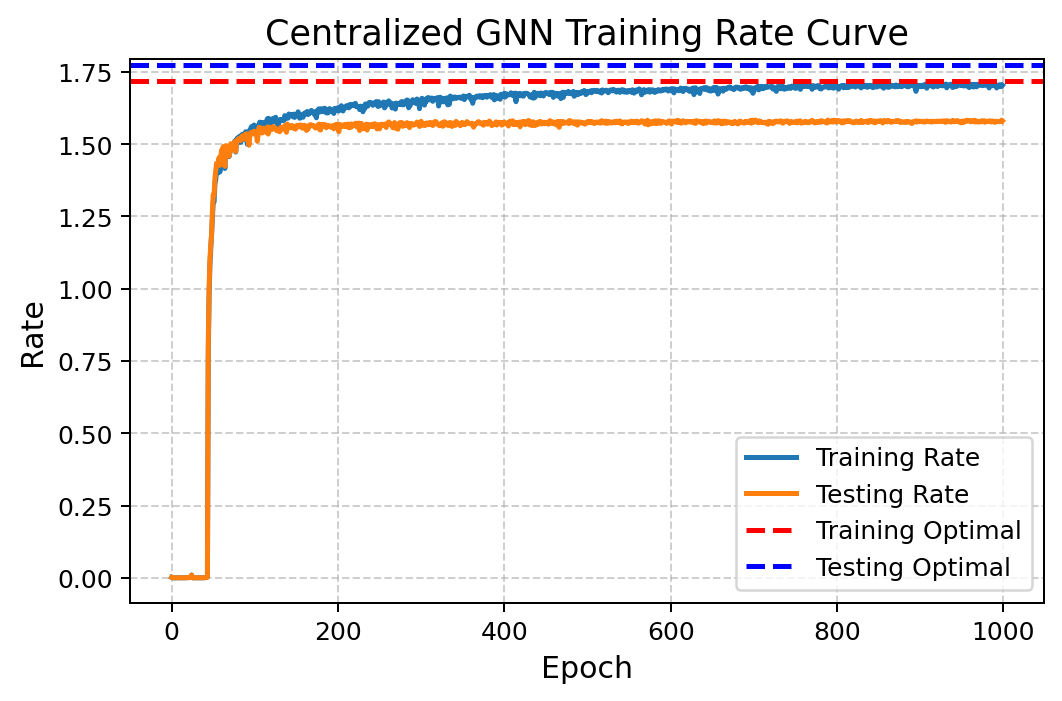

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=180)
plt.plot(all_rate, label='Training Rate', linewidth=2)
plt.plot(all_rate_test, label='Testing Rate', linewidth=2)
plt.axhline(y=np.mean(opt_train_rates[train_idx]), linewidth=2, color='r', linestyle='--', label='Training Optimal')
plt.axhline(y=np.mean(opt_train_rates[test_idx]), linewidth=2, color='b', linestyle='--', label='Testing Optimal')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('Centralized GNN Training Rate Curve', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

In [67]:
print('Different data eval...')
num_eval = 500
file_name = f'dl_data_with_power_10000_{num_ue}_{num_ap}'
# file_name = f'cf_data_1000_{num_ue}_{num_ap}'
# file_name = 'cf_data_1000_6_30'
# file_name = f'eval_data_{num_eval}_{num_ue}_{num_ap}'
eval_mat = scipy.io.loadmat('Data/' + file_name + '.mat')
Beta_eval = eval_mat['betas']
Gamma_eval = eval_mat['Gammas']
Power_eval = eval_mat['power']/rho_d
Phi_eval = eval_mat['Phii_cf'].transpose(0,2,1)

opt_rates = eval_mat['R_cf_opt_min'][0]

Label_eval = opt_rates

# beta_mean_eval = np.mean(Beta_eval)
# beta_std_eval = np.std(Beta_eval)
# Beta_eval = (Beta_eval - beta_mean_eval) / (beta_std_eval)

# eval_data = create_graph(Beta_eval, Phi_eval, beta_mean_eval, beta_std_eval,  'het')
# eval_loader = build_loader(eval_data, num_eval, seed=1712, drop_last=True)

# eval_data_cen = create_graph(Beta_eval, Phi_eval, beta_mean_eval, beta_std_eval, 'het', isDecentralized=False)
# eval_loader_cen = DataLoader(eval_data_cen, batch_size=num_eval, shuffle=True)  

eval_idx = perm[-num_eval:]
# eval_idx = perm[:num_eval]
# eval_data_cen, eval_loader_cen = build_cen_loader(Beta_eval[eval_idx], Phi_eval[eval_idx], num_eval, isShuffle=True)
opt_rates = opt_rates[eval_idx]

eval_data_cen, eval_loader_cen = build_cen_loader(
    Beta_eval[eval_idx], 
    Gamma_eval[eval_idx],
    Label_eval[eval_idx],
    Phi_eval[eval_idx], 
    num_eval
)




Different data eval...


In [68]:
cen_model.eval()
for batch in eval_loader_cen:
    batch = batch.to(device)
    num_graph = batch.num_graphs
    x_dict, edge_dict, edge_index = cen_model(batch)
    
    gnn_rates, all_one_rates = cen_loss_function(
        batch, x_dict, edge_dict,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna, 
        eval_mode=True
    )

gnn_rates = gnn_rates.detach().cpu().numpy() 
all_one_rates = all_one_rates.detach().cpu().numpy() 

In [69]:
print(f'Avg rate centralized: {np.mean(gnn_rates):0.4f}')
print(f'Avg rate opt: {np.mean(opt_rates):0.4f}')

Avg rate centralized: 1.5438
Avg rate opt: 1.7419


In [70]:
max_value = np.ceil(max(np.max(all_one_rates), np.max(gnn_rates), np.max(opt_rates))*100)/100

In [71]:
min_rate, max_rate = 0, max_value
# y_axis = np.arange(0, 1.0, 1/202)
y_axis = np.linspace(0, 1, num_eval+2)
gnn_rates.sort();  opt_rates.sort(); all_one_rates.sort();
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,num_eval+1,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,num_eval+1,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_eval+1,max_rate)

# Visualization

In [72]:
import matplotlib.pyplot as plt


# Check the fucking power thresh

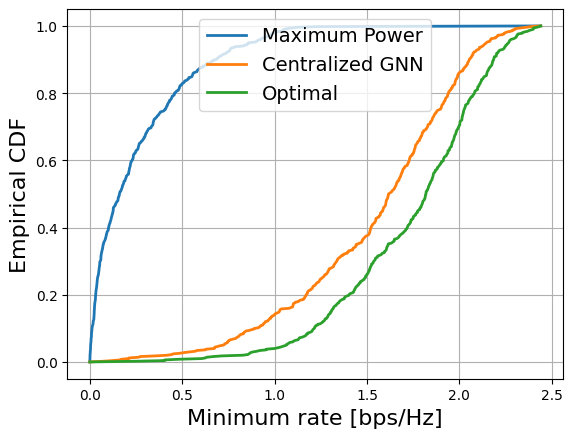

In [73]:
plt.plot(all_one_rates, y_axis, label = 'Maximum Power', linewidth=2)
plt.plot(gnn_rates, y_axis, label = 'Centralized GNN', linewidth=2)
plt.plot(opt_rates, y_axis, label = 'Optimal', linewidth=2)
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Test

In [ ]:
all_rate = []
eval_epochs_cen = num_epochs_cen//10 if num_epochs_cen//10 else 1
print(f'Training Centralized GNN for benchmark...')
for epoch in range(num_epochs_cen):
    cen_model.train()
    train_loss, train_rate = cen_train(
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
        test_eval = cen_eval(
            test_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
    all_rate.append(train_rate.cpu())    
    cen_scheduler.step()
    if epoch%eval_epochs_cen==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs_cen} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Loss: {train_rate:.4f} | "
            f"Train Rate: {train_eval:.4f} | "
            f"Test Rate: {test_eval:.4f} "
        )

In [ ]:
from Utils.comm import variance_calculate, rate_from_component, component_calculate
Beta_all = eval_mat['betas'][:10]
Phi_all = eval_mat['Phii_cf'][:10].transpose(0,2,1)

dtype = torch.float64 

num_sam, num_ap, num_ue = Beta_all.shape

largeScaleMat = torch.tensor(Beta_all, dtype=dtype)
pilotMatrix = torch.tensor(Phi_all, dtype=dtype)
chanelVarMat = variance_calculate(largeScaleMat, pilotMatrix, tau, power_f)

powerMat = torch.rand(Beta_all.shape, dtype=dtype)

all_DS, all_PC, all_UI = component_calculate(powerMat, chanelVarMat, largeScaleMat, pilotMatrix, rho=power_f)
rate_mat = rate_from_component(all_DS, all_PC, all_UI, num_antenna)

In [ ]:
PC = torch.zeros(num_sam, num_ue, num_ue, dtype=dtype)
SINR = torch.zeros(num_sam, num_ue, dtype=dtype)
UI = torch.zeros(num_sam, num_ue, dtype=dtype)

for each_sam in range(num_sam):
    for k_prime in range(num_ue):
        for k in range(num_ue):
            pc = pilotMatrix[each_sam, k_prime, :] @ pilotMatrix[each_sam, k, :] 
            tmp = torch.sqrt(powerMat[each_sam,:,k_prime]) *  chanelVarMat[each_sam,:,k_prime] * largeScaleMat[each_sam,:,k] / largeScaleMat[each_sam,:,k_prime]
            PC[each_sam, k_prime, k] =  torch.sum(tmp) * pc
        
PC = torch.square(PC)

for each_sam in range(num_sam):
    for k in range(num_ue):
        for k_prime in range(num_ue):
            tmp = powerMat[each_sam, :, k_prime] * chanelVarMat[each_sam,:, k_prime] * largeScaleMat[each_sam,:,k]
            UI[each_sam, k] += torch.sum(tmp)
for each_sam in range(num_sam):
    for k in range(num_ue):
        num = 0
        for m in range(num_ap):
            num += torch.sqrt(powerMat[each_sam,m,k]) * chanelVarMat[each_sam,m,k]
        SINR[each_sam, k] = torch.square(num)/(1 + UI[each_sam, k] + torch.sum(PC[each_sam,:,k]) - PC[each_sam,k,k])
        
rate = torch.log2(1+SINR)

In [ ]:
print(rate_mat.dtype)          # should show torch.float64
print(rate.dtype)              # from loop version, also float64
print((rate_mat - rate).abs().max())